In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 

from utils import mlp,train_test_model
from utils.scp_utils.scp import SCP
from utils.scp_utils.scp_v2 import SCP as SCP_v2
from utils.ewc_utils.onlineEWC import OnlineEWC
from utils.mas_utils.mas import MAS

from data.permuted_MNIST import get_permuted_mnist

In [2]:
import os

results_folder='perm_mnist_10Run/'

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)

## Set configurations

In [3]:
epochs = 20
lr = 1e-4 
batch_size = 100 
input_size = 784
hidden_sizes = [1024,512,256]
output_size = 10

num_task = 10
n_slices = 100

activation='ReLU'
device='cuda:0'

ewc_alpha=0.25
scp_alpha=0.25
mas_alpha=0.25

scp_importance=1e+7
mas_importance=2e+4
ewc_importance=1e+4

## Load dataset

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f829f800400>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/conda/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_proces

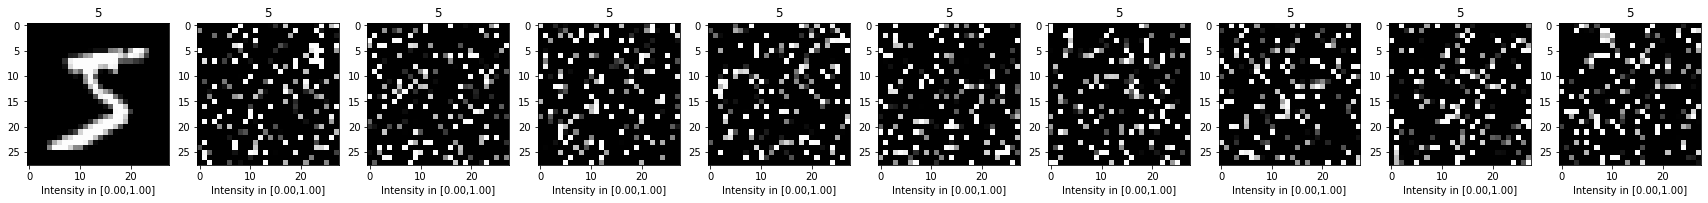

In [4]:
train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

## First we perform sequential learning with standard MLP 

In [5]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)

## Perform training
loss, acc = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss[task] = []
    acc[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss[task].append(train_test_model.train_classifier(model=model,
                                                            optimizer=optimizer,
                                                            data_loader=train_loader[task],
                                                            device=device))            
        for sub_task in range(task + 1):
            acc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))
            
    torch.save(model.state_dict(), 'saved_models/model_standard_'+str(task)+'.pt') 

Text(0.5, 0.98, 'Catastrophic forgetting')

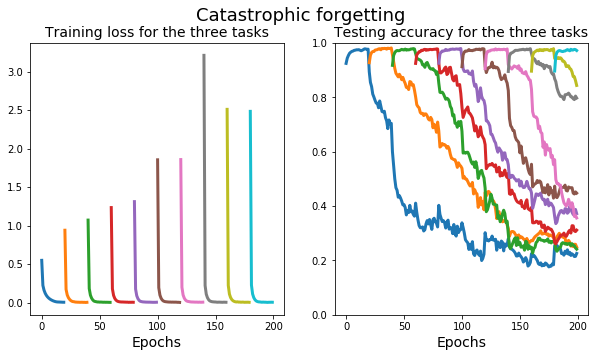

In [6]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Catastrophic forgetting',fontsize=18)

## Next we perform onlineEWC 

In [7]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
ewc= OnlineEWC(model,device=device,alpha=ewc_alpha)


average_importance=0
for i,n in enumerate(ewc._precision_matrices.keys()):
    average_importance+=ewc._precision_matrices[n].detach().cpu().numpy().mean()
average_importance/=i
print(average_importance)

## performing training
loss_ewc, acc_ewc = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss_ewc[task] = []
    acc_ewc[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_ewc[sub_task].append(train_test_model.test_classifier(model=ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    ewc.consolidate(train_loader[task])    
    importance_EWC=list()
    for i,n in enumerate(ewc._precision_matrices.keys()):
        importance_EWC.append(ewc._precision_matrices[n].detach().cpu().numpy())
#     average_importance/=i
#     print(average_importance)

    torch.save(ewc.model.state_dict(), 'saved_models/model_ewc_'+str(task)+'.pt') 

0.0


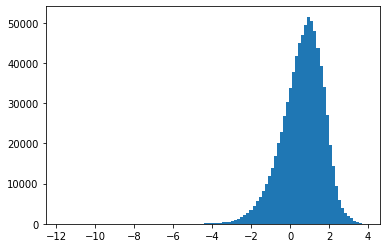

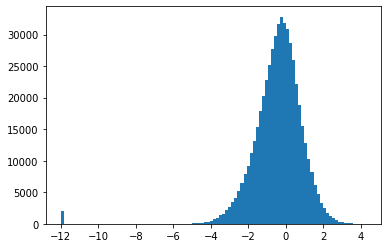

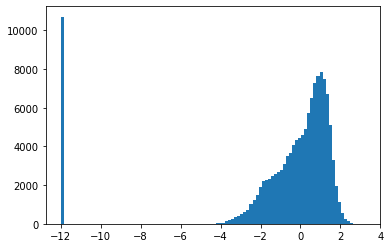

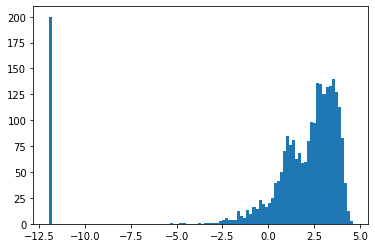

In [8]:
for f in importance_EWC:
    plt.hist(np.log10((1e+4)*f.reshape(-1)+1e-12),bins=100)
    plt.show()

Text(0.5, 0.98, 'Using EWC Regularizer')

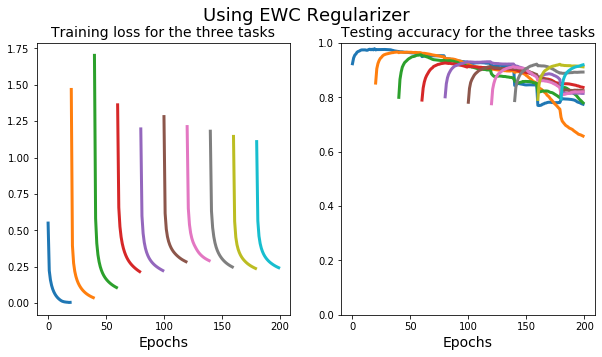

In [9]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using EWC Regularizer',fontsize=18)

## Next we perform MAS

In [10]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
mas= MAS(model,device=device,alpha=mas_alpha)
## performing training
loss_mas, acc_mas = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss_mas[task] = []
    acc_mas[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_mas[task].append(train_test_model.mas_train_classifier(mas=mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_mas[sub_task].append(train_test_model.test_classifier(model=mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    mas.consolidate(train_loader[task])    
    torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
    
    importance_MAS=list()
    for i,n in enumerate(mas._precision_matrices.keys()):
        importance_MAS.append(mas._precision_matrices[n].detach().cpu().numpy())

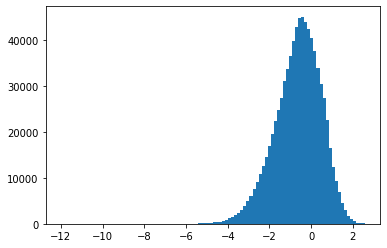

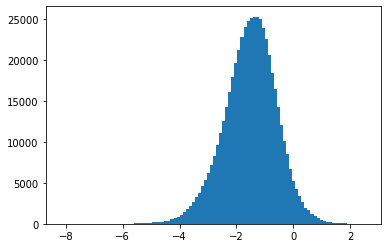

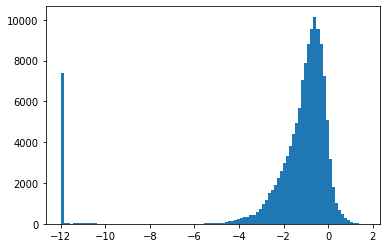

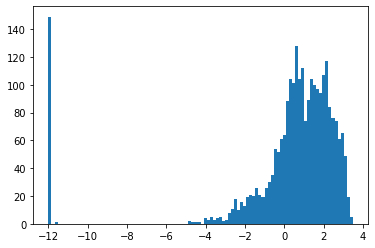

In [11]:
for f in importance_MAS:
    plt.hist(np.log10((2e+4)*f.reshape(-1)+1e-12),bins=100)
    plt.show()

Text(0.5, 0.98, 'Using MAS Regularizer')

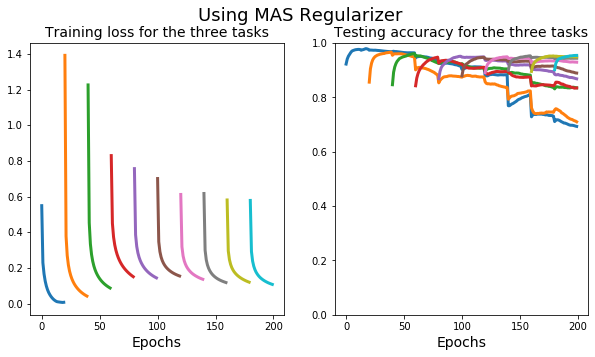

In [12]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using MAS Regularizer',fontsize=18)

## Next we perform SCP

In [13]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
scp= SCP(model,device=device,alpha=scp_alpha,n_slices=n_slices)
## performing training
loss_scp, acc_scp = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss_scp[task] = []
    acc_scp[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_scp[task].append(train_test_model.scp_train_classifier(scp=scp,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=scp_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_scp[sub_task].append(train_test_model.test_classifier(model=scp.model,
                                                                     data_loader=test_loader[sub_task],
                                                                     device=device))            
    scp.consolidate(train_loader[task])    
    torch.save(scp.model.state_dict(), 'saved_models/model_scp_'+str(task)+'.pt') 
    
    importance_SCP=list()
    for i,n in enumerate(scp._precision_matrices.keys()):
        importance_SCP.append(scp._precision_matrices[n].detach().cpu().numpy())

100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


100%|██████████| 100/100 [00:15<00:00,  5.97it/s]


100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


100%|██████████| 100/100 [00:15<00:00,  5.97it/s]


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


100%|██████████| 100/100 [00:16<00:00,  5.82it/s]


100%|██████████| 100/100 [00:14<00:00,  7.56it/s]


100%|██████████| 100/100 [00:15<00:00,  6.82it/s]


100%|██████████| 100/100 [00:16<00:00,  4.97it/s]


100%|██████████| 100/100 [00:15<00:00,  6.14it/s]


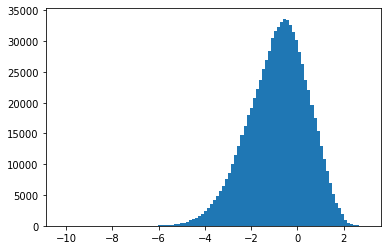

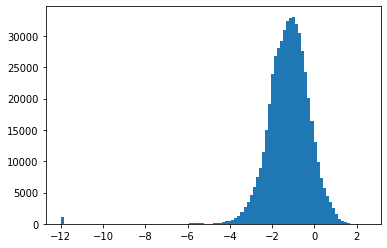

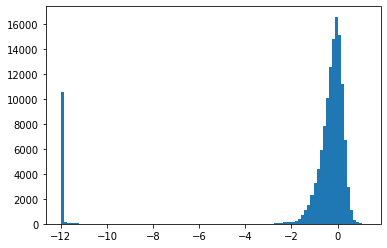

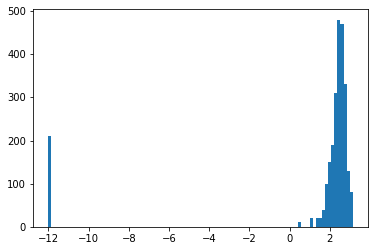

In [14]:
for f in importance_SCP:
    plt.hist(np.log10((1e+7)*f.reshape(-1)+1e-12),bins=100)
    plt.show()

In [15]:
import pickle
pickle.dump([importance_EWC,importance_MAS,importance_SCP],open('importance_parameters_10Tasks.pkl','wb'))

Text(0.5, 0.98, 'Using SCP Regularizer')

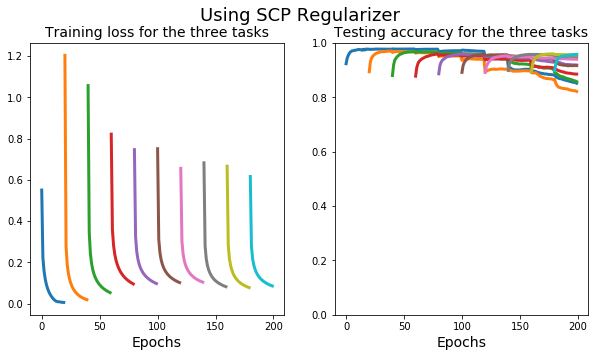

In [16]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SCP Regularizer',fontsize=18)

In [17]:

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
scp_v2= SCP_v2(model,device=device,alpha=scp_alpha,n_slices=1)
## performing training
loss_scp_v2, acc_scp_v2 = {}, {}
for task in tqdm_notebook(range(num_task)):
    loss_scp_v2[task] = []
    acc_scp_v2[task] = []
    for _ in tqdm_notebook(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_scp_v2[task].append(train_test_model.scp_train_classifier(scp=scp_v2,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=1e+2,
                                                                    device=device))
        for sub_task in range(task + 1):
            acc_scp_v2[sub_task].append(train_test_model.test_classifier(model=scp_v2.model,
                                                                     data_loader=test_loader[sub_task],
                                                                     device=device))
    scp_v2.consolidate(train_loader[task])

100%|██████████| 600/600 [00:01<00:00, 354.34it/s]


100%|██████████| 600/600 [00:01<00:00, 348.92it/s]


100%|██████████| 600/600 [00:01<00:00, 344.64it/s]


100%|██████████| 600/600 [00:01<00:00, 333.62it/s]


100%|██████████| 600/600 [00:01<00:00, 325.08it/s]


100%|██████████| 600/600 [00:01<00:00, 365.23it/s]


100%|██████████| 600/600 [00:01<00:00, 358.38it/s]


100%|██████████| 600/600 [00:01<00:00, 358.49it/s]


100%|██████████| 600/600 [00:01<00:00, 371.43it/s]


100%|██████████| 600/600 [00:02<00:00, 299.21it/s]

Text(0.5, 0.98, 'Using SCP_V2 Regularizer')

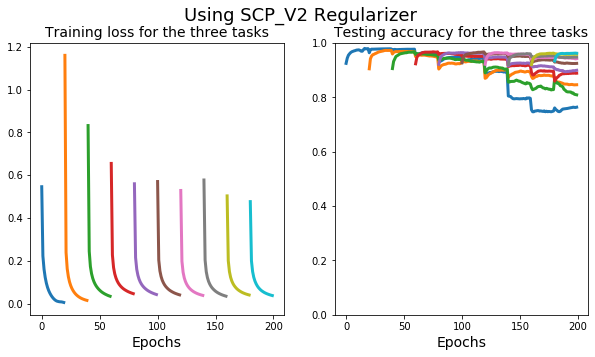

In [18]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_scp_v2.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_scp_v2.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SCP_V2 Regularizer',fontsize=18)

In [19]:
def get_mean_acc(acc,epochs):
    num_task=len(acc)
    temp=np.zeros((num_task,len(acc[0])))
    for t,v in acc.items():
        temp[t,range(t * epochs, num_task * epochs)]=v
        if t<num_task-1:
            temp[t+1,:]=temp[:t+1,:].mean(0)
    return temp.mean(0)

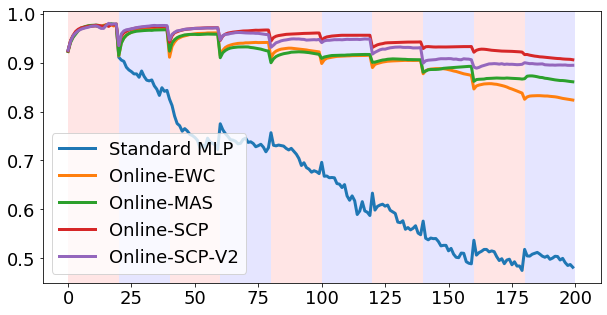

In [20]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
plt.plot(get_mean_acc(acc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_ewc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_mas,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_scp,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_scp_v2,epochs),linewidth=3)
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['Standard MLP','Online-EWC','Online-MAS','Online-SCP','Online-SCP-V2'],fontsize=18)
plt.show()


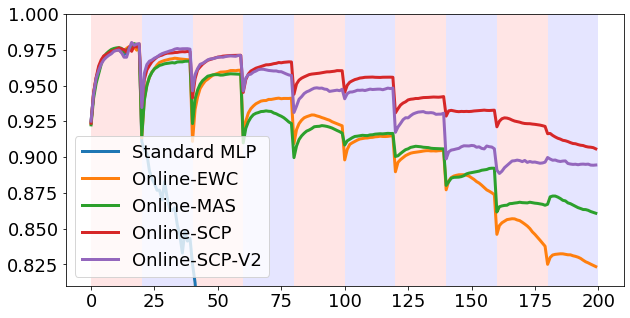

In [21]:
plt.figure(figsize=(10,5))
for t in range(num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t*epochs, (t+1)*epochs, facecolor=c, alpha=0.1)
plt.plot(get_mean_acc(acc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_ewc,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_mas,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_scp,epochs),linewidth=3)
plt.plot(get_mean_acc(acc_scp_v2,epochs),linewidth=3)
plt.ylim(.81,1.) 
plt.xticks(fontsize=18),plt.yticks(fontsize=18)
plt.legend(['Standard MLP','Online-EWC','Online-MAS','Online-SCP','Online-SCP-V2'],fontsize=18)
plt.show()


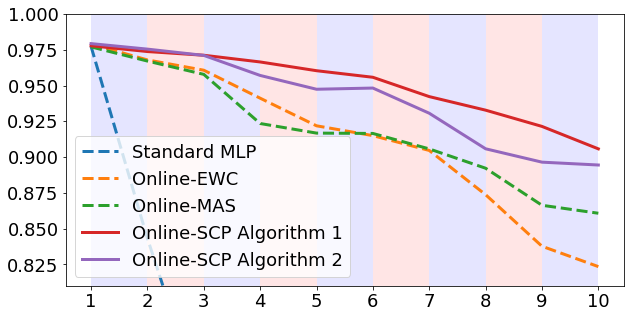

In [22]:
plt.figure(figsize=(10,5))
for t in range(1,num_task):
    if t%2:
        c='b'
    else:
        c='r'
    plt.axvspan(t, (t+1), facecolor=c, alpha=0.1)
inds=np.arange(19,200,20)
x=np.arange(1,11)
plt.plot(x,get_mean_acc(acc,epochs)[inds],'--',linewidth=3)
plt.plot(x,get_mean_acc(acc_ewc,epochs)[inds],'--',linewidth=3)
plt.plot(x,get_mean_acc(acc_mas,epochs)[inds],'--',linewidth=3)
plt.plot(x,get_mean_acc(acc_scp,epochs)[inds],linewidth=3)
plt.plot(x,get_mean_acc(acc_scp_v2,epochs)[inds],linewidth=3)
plt.xticks(x,fontsize=18),plt.yticks(fontsize=18)
plt.ylim(.81,1.) 
plt.legend(['Standard MLP','Online-EWC','Online-MAS','Online-SCP Algorithm 1','Online-SCP Algorithm 2'],fontsize=18)
plt.show()


In [23]:
import pickle
iteration=9
pickle.dump([[loss,loss_ewc,loss_mas,loss_scp,loss_scp_v2],
                 [acc,acc_ewc,acc_mas,acc_scp,acc_scp_v2]],
                 open(results_folder+'experiment_%d.pkl'%iteration,'wb'))